In [23]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io.gtfs_reader import  gtfs_importer
from quetzal.model import stepmodel

import geopandas as gpd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

In [24]:
work_path = r'../../../'
input_folder= work_path + r'quetzal_santo_domingo/inputs/'
gtfs_zip = input_folder + 'gtfs-Santo_Domingo-base.zip'
gtfs_folder = input_folder + r'/input_gtfs/'

In [25]:
import shutil
import os

try:
    shutil.rmtree(gtfs_folder)
except FileNotFoundError:
    pass
os.mkdir(gtfs_folder)
shutil.unpack_archive(gtfs_zip, gtfs_folder)

In [26]:
importer = gtfs_importer.BaseGtfsImporter(gtfs_folder)
importer.read()

In [27]:
d = importer.stop_times.groupby(['trip_id']).first()['stop_id']
importer.trips['direction_id'] = importer.trips['trip_id'].apply(lambda i: d[i])

In [28]:
importer.stop_times.head(1)

,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_id,trip_id,arrival_time,departure_time
0,0,NaN,NaN,NaN,0.0,NaN,564147,first trip_27,0:00:00,0:00:30


In [44]:
print(set(importer.routes['route_short_name']))

{'m1', 'm2_este', 'sitp_prolongacion_27', 'tramo SDO L2', 'sanfelipe', 'ecologico', 'victoria', 'm3', 'tele_alcarrizos', 'tele_este', 'm2', 'sitp_duarte', '27_febrero', 'sitp_cdg_oeste', 'Tele Oeste LA', 'sitp_tiradentes', 'monumental', 'luperon', 'sitp_josefa', 'Tele Oeste SDO', 'tele_norte', 'sitp_lincoln', 'pantoja', 'sitp_cdg_este', 'sitp_defillo', 'm2_oeste', 'sitp_churchill', 'tele_oeste', 'independencia', 'herrera', 'm2_completo', 'tram_oeste', 'intrant', 'mella', 'sitp_nunez', 'sitp_sabana_larga', 'tram_este', 'sitp_venezuela', 'Tramo Alcarrizos L2', '27_febrero_oeste', 'sitp_marzo', 'sitp_ortega', 'quentin'}


In [30]:
importer.routes.sort_values('route_type')[['route_short_name', 'route_type']].to_csv(input_folder + 'test.csv', sep=';')

In [31]:
importer.cast_columns_to_string(columns=['trip_id', 'route_id', 'stop_id'])

stop_times ['stop_id', 'trip_id'] converted to string
trips ['route_id', 'trip_id'] converted to string
routes ['route_id'] converted to string
stops ['stop_id'] converted to string


# renumber

In [32]:
start_from = 1000000
proto = importer.stops.sort_values('stop_id').reset_index(drop=True)
proto.index = proto.index + start_from
r_dict = proto.reset_index().set_index(['stop_id'])['index'].to_dict()
importer.stops['stop_id'] =importer.stops['stop_id'].apply(lambda i: r_dict[i]) 
importer.stop_times['stop_id'] =importer.stop_times['stop_id'].apply(lambda i: r_dict[i]) 

# build links and nodes

In [33]:
importer.build()
importer.links.head(1)

,index,a,trip_id,link_sequence,departure_time,b,arrival_time,time,route_id,direction_id,...,service_id,route_long_name,route_short_name,route_desc,route_type,route_url,route_color,route_text_color,agency_id,geometry
0,0,1000063,first trip_27,0,30.0,1000182,196.0,166.0,17351,564147,...,Martes,27_febrero,27_febrero,NaN,3,NaN,3f6d51,NaN,NaN,"LINESTRING (-69.848974 18.485057, -69.85553900..."


# rename route types

In [34]:
importer.links['route_type'] = importer.links['route_type'].apply(
    lambda t: {
        0:'tram',
        1:'subway',
        2:'rail',
        3:'bus',
        4:'ferry',
        5:'cable_car',
        6:'gondola',
        7:'funicular',
        702: 'express_bus'
    }[t]
)

# export 

In [35]:
sm = stepmodel.StepModel()
sm.links = importer.links
sm.nodes = importer.stops.set_index('stop_id')[['geometry']]

In [36]:
sm.nodes['stop_id'] = sm.nodes.index

<AxesSubplot:>

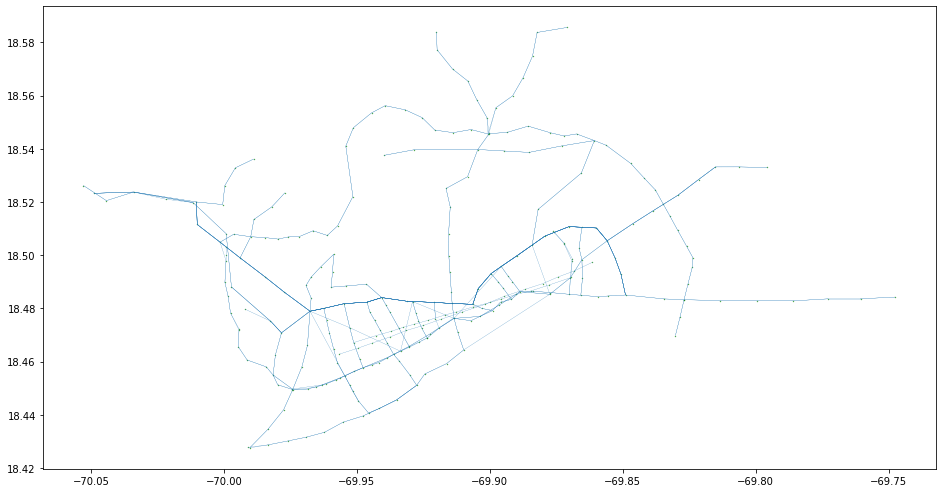

In [37]:
plot = gpd.GeoDataFrame(sm.links).plot(linewidth=0.2)
gpd.GeoDataFrame(sm.nodes).plot(ax=plot, color='green', markersize=0.1)

In [38]:
sm.to_json(input_folder + 'gtfs')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.67it/s]


could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values


In [39]:
sm.to_json(input_folder + 'gtfs', only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 66.92it/s]


In [46]:
training_folder = '../../'
sm.links['route_id'] = sm.links['route_short_name']
sm.to_zip(training_folder + 'model/preparation/gtfs.zip')

jsons: 100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 69.03it/s]


In [42]:
set(sm.links.loc[sm.links['route_type'] == 'subway']['route_id'])

{'intrant', 'm1', 'm2', 'm2_completo', 'm2_este', 'm2_oeste', 'm3', 'quentin'}

In [43]:
set(sm.links.loc[sm.links['route_type'] == 'bus']['route_id'])

{'27_febrero',
 'independencia',
 'sanfelipe',
 'sitp_cdg_este',
 'sitp_cdg_oeste',
 'sitp_churchill',
 'sitp_defillo',
 'sitp_josefa',
 'sitp_lincoln',
 'sitp_nunez',
 'sitp_ortega',
 'sitp_prolongacion_27',
 'sitp_sabana_larga',
 'sitp_tiradentes',
 'sitp_venezuela',
 'victoria'}